# PINN for Laplace Equation - Training on Dataset
(Please reference to our paper **Physics-Informed Boundary Integral Networks (PIBI-Nets): a Data-Driven Approach for Solving Partial Differential Equations**.)


## Problem setup

### Laplace equation 
$$ \Delta u(x) := \frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} = 0 $$

$$x:=(x_1, x_2)\, \in \,\left([-1,1]\times [-1,1]\right)=:\Omega \subseteq \mathbb{R}^2$$

### Uniformal sampled datapoints based on FD solution given by Dirichlet boundary conditions
Let ${\large\{}u_i(x){\large\}}_{i=0}^{i=N}$ be the measurements constructed by a finite difference solution of the Laplace equation based on Dirichlet boundary conditions


## Load packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # colormaps
from matplotlib.font_manager import FontProperties

In [2]:
import pandas as pd
import os

In [3]:
matplotlib.rcParams['text.usetex'] = True
# font properties for plot titles
font_axis = FontProperties()
font_axis.set_family('serif')
font_axis.set_name('Times New Roman')
font_axis.set_size(115) 
# font properties for 3d plot titles
font_axis_3d = FontProperties()
font_axis_3d.set_family('serif')
font_axis_3d.set_name('Times New Roman')
font_axis_3d.set_size(90)  

## Dataset setup

In [4]:
# read data from CSV file into a pandas DataFrame and save as Torch tensor
def read_data(csv_file):
    """
    read csv file and store data in x_data, u_data
    
    Args:
    - csv_file
    
    Returns:
    - x_data: tensor of shape (N,2) containing N positions x=(x1,x2)
    - u_data: tensor of shape (N,1) containing u values to corresponding x
    
    """   
    
    # read data from CSV file into a pandas DataFrame and save as Torch tensor
    data_pd = pd.read_csv(csv_file)
    # convert pandas DataFrame to PyTorch tensor
    data_tensor = torch.tensor(data_pd.values, dtype=torch.float32) # x1, x2, u
    x_data = data_tensor[:,0:2] 
    u_data = data_tensor[:,2].view(-1,1)
    
    return x_data, u_data

x_data, u_data = read_data('dataset_laplace.csv')

In [5]:
x_new = []
u_new = []
x_remove = []
x_data = np.array(x_data)
u_data = np.array(u_data)
limit = 0.8

for k in range(u_data.shape[0]):
    if (-limit < x_data[k,0]) & (x_data[k,0]<limit) & (-limit < x_data[k,1]) & (x_data[k,1]<limit):
        x_remove.append(x_data[k,:])
    else:
        x_new.append(x_data[k,:])
        u_new.append(u_data[k,:])

        
x_data = torch.tensor(np.array(x_new))
u_data = torch.tensor(np.array(u_new))
x_data.shape

torch.Size([30, 2])

## Physics initialisation

In [6]:
#  pde function, given a network nnet
def pde(x, u):
    """
    computes physics given by pde, where solution u of pde is computed by neural network net at position x=(x1,x2) in Omega
    
    Args:
    - x: tensor of shape (N,2) containing N positions (x1, x2) in Omega
    - u: tensor of shape (N,1) given by neural network that has 2 dimensional first layer and a one dimensional output layer
    
    Returns:
    - u_pde: tensor of shape (N,1) containing the pde at each position in x
    
    """   
    
    # compute gradients for pde
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0] # (du_dx1, du_dx2) of shape (N,2)
    d2u_dx1x1 = torch.autograd.grad(du_dx[:,0], x, grad_outputs=torch.ones_like(du_dx[:,0]), create_graph=True)[0][:,0].view(-1,1) # (d2u_dx1x1, d2u_dx1x2), but only take first column, shape (N,1)
    d2u_dx2x2 = torch.autograd.grad(du_dx[:,1], x, grad_outputs=torch.ones_like(du_dx[:,1]), create_graph=True)[0][:,1].view(-1,1) # (d2u_dx2x1, d2u_dx2x2), but only take second column, shape (N,1)
    
    # compute pde
    u_pde = d2u_dx1x1 + d2u_dx2x2
    
    return u_pde

## Collocation points

In [7]:
def collocation_points(n):

    # number of collocation points over entire domain for physics / pde loss
    x1_collocation = torch.FloatTensor(n, 1).uniform_(-1, 1)
    x2_collocation = torch.FloatTensor(n, 1).uniform_(-1, 1)
    x_collocation = torch.cat([x1_collocation, x2_collocation], axis=1).requires_grad_(True) 
    
    return x_collocation

## FD mesh

In [8]:
# read data from CSV file into a pandas DataFrame and save as Torch tensor
x_num = pd.read_csv('X_mesh.csv')
# convert pandas DataFrame to PyTorch tensor
x_num = torch.tensor(x_num.values, dtype=torch.float32) 

# read data from CSV file into a pandas DataFrame and save as Torch tensor
u_num = pd.read_csv('u_num.csv')
# convert pandas DataFrame to PyTorch tensor
u_num = torch.tensor(u_num.values, dtype=torch.float32) 

N = u_num.shape
N

torch.Size([10201, 1])

## Network setup

In [9]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers):
        """
        class implementation of a fully-connected neural network with PyTorch given by Args
        
        Args:
        - N_input: integer, number of input dimension, here N_input = 2 given by x=(x1, x2)
        - N_output: integer, number of output dimession, here N_output = 1 given by u(x)
        - N_hidden: integer, depth of one hidden layer
        - N_layers: integer, number of hidden layers in the network
        
        Methods:
        - forward: forward pass of neural network
        
        """  
        super().__init__()  
        activation = nn.Tanh
        
        #self.myparam = nn.Parameter(nn.ones((1,)))
        
        # input / start layer
        self.fc_start = nn.Sequential(*[ 
                                nn.Linear(N_input, N_hidden),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden),
                                    activation()
                                    ]) 
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output) # for regression, no activation is used in output layer
        
        
    def forward(self, x):
        """
        forward pass through network building blocks given in this class above
        
        Args:
        - x: tensor of shape (N, 2) containing N positions (x1, x2)

        Returns:
        - u: tensor of shape (N,1) containing the network solution u at position x
        
        """ 
        # forward network
        x = self.fc_start(x)  # input layer
        x = self.fc_hidden(x) # hidden layer(s)
        u = self.fc_end(x)    # output layer   
        
        return u

In [10]:
def initialise_pinn(lr):
    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 512 # changeable, use 2**n for efficient memory usage and computation
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pinn = FCNN(N_input, N_output, N_hidden, N_layers)

    # optimizer
    optimiser = torch.optim.Adam(pinn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, eps=1e-12, verbose=True)

    # loss function
    mse_loss = torch.nn.MSELoss() # Mean squared error
    
    return pinn, optimiser, scheduler, mse_loss

## Train PINN and visualise trained solution

In [18]:
def train_pinn(iterations, lambda_physics, n_coll, pinn, optimiser, scheduler, mse_loss):

    # store loss values
    loss_values = []

    for epoch in range(iterations):
        # Clear gradients before forward and backward pass for each batch to avoid accumulation of gradients
        optimiser.zero_grad()

        # compute data loss
        u = pinn(x_data) # forward pass
        loss_data = mse_loss(u, u_data)

        # compute physics loss
        x_collocation = collocation_points(n)
        u = pinn(x_collocation)
        loss_pde = (mse_loss(torch.zeros_like(u), pde(x_collocation, u)))

        # backpropagate weighted joint loss, take optimiser step
        loss = loss_data + lambda_physics*loss_pde
        loss_values.append(loss.item()) # store loss value for convergence plot
        loss.backward()
        optimiser.step()
        scheduler.step(loss)

        # plot result as training progresses on test set
        if epoch % 10 == 0: 
            print('epoch:', epoch, ', data:', loss_data.data, 'physics:', loss_pde.data)

            if epoch == iterations-1: 
                # save model, see also https://pytorch.org/tutorials/beginner/saving_loading_models.html
                torch.save(pinn.state_dict(), "pinn_model.pt")
                
                u = torch.squeeze(pinn(x_num).detach()) 
                # variables on grid X1_test, X2_test
                x1 = (x_num[:,0]).reshape((101, 101))
                x2 = (x_num[:,1]).reshape((101, 101)) 
                u_nn = u.reshape(x1.shape) 
                
                # evaluation plot in 3D
                fig = plt.figure(figsize=(15,15))
                ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
                surf = ax.plot_surface(x1, x2, u_nn, cmap=cm.jet, zorder=1, alpha=1)
                ax.scatter(x_data[:,0], x_data[:,1], u_data, c='black', marker='o', s=10**2, alpha=1, zorder=2)
                surf.set_clim(vmin=-1, vmax=1) # limits to colorbar
                #fig.colorbar(surf, shrink=0.45, aspect=10, pad=0.2)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                #fig.axes[1].tick_params(axis="both", labelsize=45)
                # axis ticks
                ax.tick_params(axis="both", labelsize=60, pad=20)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                ax.set_zticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                ax.tick_params(axis='z', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_ylabel('$x_2$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_zlabel('$u$', fontproperties=font_axis_3d, labelpad=55)
                #plt.title(f"PINN at epoch {epoch}", size=20)
                # Save the figure as a JPEG image
                plt.savefig('pinn_3d_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                
                # evaluation plot in 2d
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_nn, cmap='jet', origin='lower', 
                                extent=[torch.min(x1).item(), torch.max(x1).item(), 
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=-1, vmax=1)
                ax.scatter(x_data[:,0], x_data[:,1], c='black', marker='o', s=10**2, alpha=1, zorder=4)
                #fig.colorbar(img, ax=ax, shrink=0.55, aspect=10, pad=0.2)
                # tick sizes
                fig.axes[0].tick_params(axis="both", labelsize=20)
                #fig.axes[1].tick_params(axis="both", labelsize=45)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                #plt.title(f"PINN at epoch {epoch} (Top view)", size=20)
                # Save the figure as a JPEG image
                plt.savefig('pinn_2d_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                
                # absolute error plot
                u_num_matrix = u_num.reshape(u_nn.shape)
                u_error = torch.abs(u_nn-u_num_matrix)
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_error, cmap='jet_r', origin='lower', 
                                extent=[torch.min(x1).item(), torch.max(x1).item(), 
                                        torch.min(x2).item(), torch.max(x2).item()], 
                                vmin=0, vmax=1.3)
                ax.scatter(x_data[:,0], x_data[:,1], c='black', marker='o', s=10**2, alpha=1, zorder=4)
                #fig.colorbar(img, ax=ax, shrink=0.55, aspect=10, pad=0.2)
                # tick sizes
                fig.axes[0].tick_params(axis="both", labelsize=20)
                #fig.axes[1].tick_params(axis="both", labelsize=45)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                #plt.title('Absolute error (Top View)', size=20)
                plt.savefig('pinn_error_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                u_vec = u_error.reshape(N,1)
                print('min', torch.min(u_vec), 'max', torch.max(u_vec), 'mean', torch.mean(u_vec))
        
    return loss_values, pinn

epoch: 0 , data: tensor(0.2790) physics: tensor(0.0033)
epoch: 10 , data: tensor(0.1262) physics: tensor(0.1240)
epoch: 20 , data: tensor(0.0924) physics: tensor(0.1736)
epoch: 30 , data: tensor(0.0660) physics: tensor(0.3303)
epoch: 40 , data: tensor(0.0506) physics: tensor(0.5824)
epoch: 50 , data: tensor(0.0410) physics: tensor(1.0235)
epoch: 60 , data: tensor(0.0384) physics: tensor(1.4556)
epoch: 70 , data: tensor(0.0356) physics: tensor(1.6655)
epoch: 80 , data: tensor(0.0335) physics: tensor(1.7234)
epoch: 90 , data: tensor(0.0315) physics: tensor(2.1892)
epoch: 100 , data: tensor(0.0299) physics: tensor(2.7575)
epoch: 110 , data: tensor(0.0283) physics: tensor(3.2790)
epoch: 120 , data: tensor(0.0264) physics: tensor(4.2568)
epoch: 130 , data: tensor(0.0239) physics: tensor(4.7752)
epoch: 140 , data: tensor(0.0250) physics: tensor(5.7064)
epoch: 150 , data: tensor(0.0164) physics: tensor(8.6344)
epoch: 160 , data: tensor(0.0127) physics: tensor(12.3253)
epoch: 170 , data: tenso

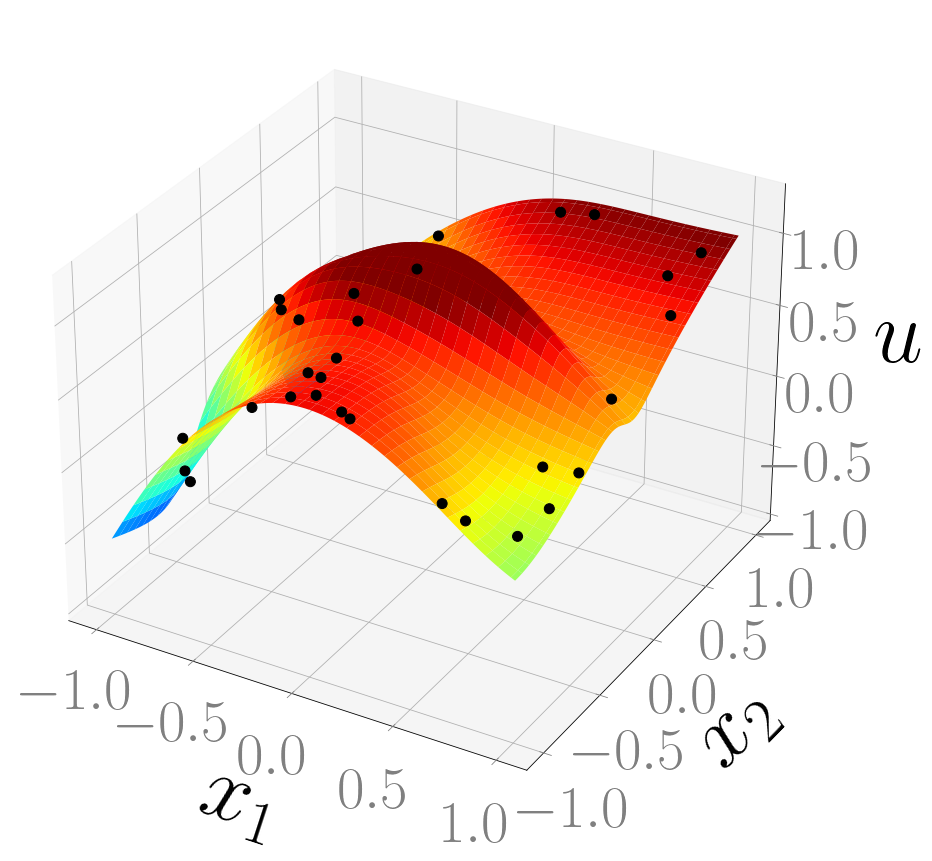

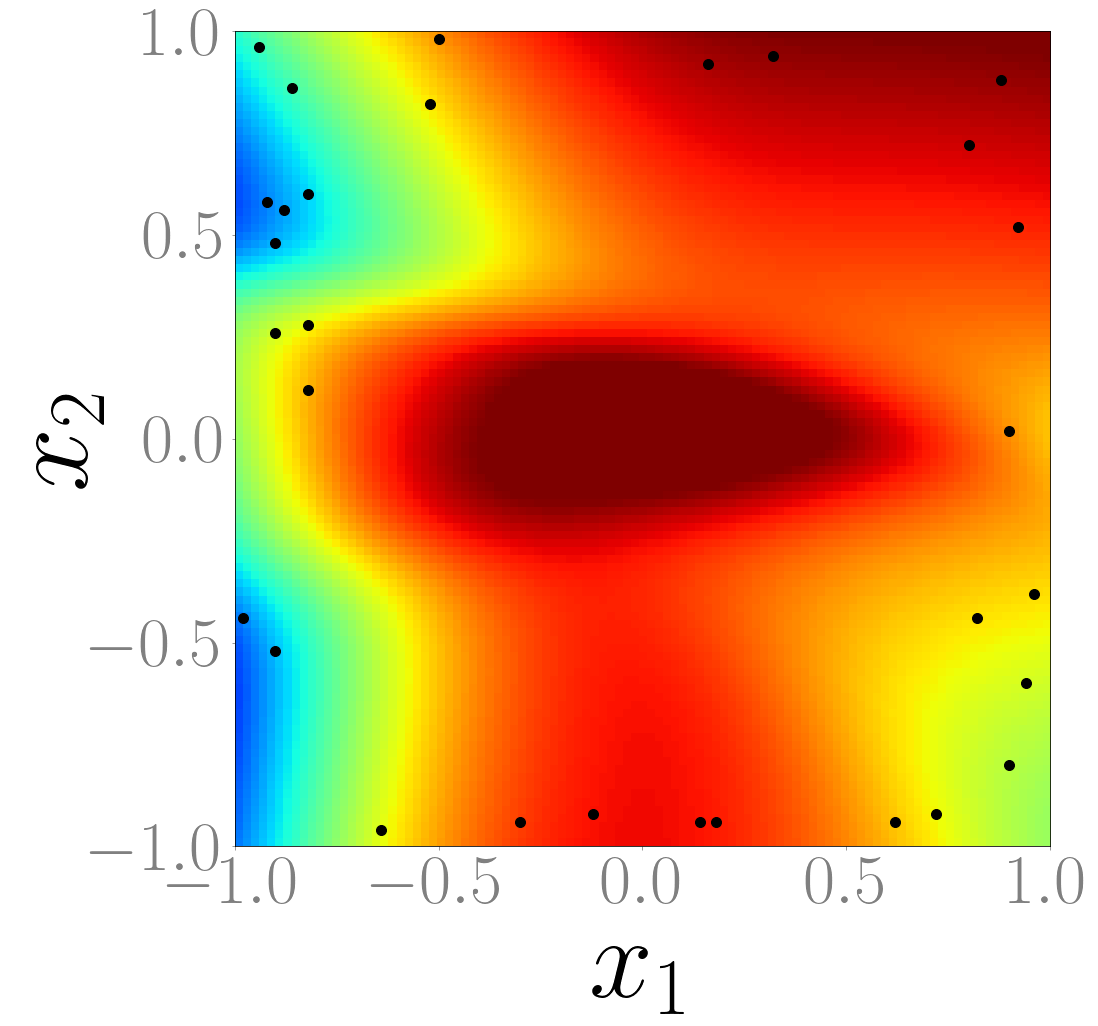

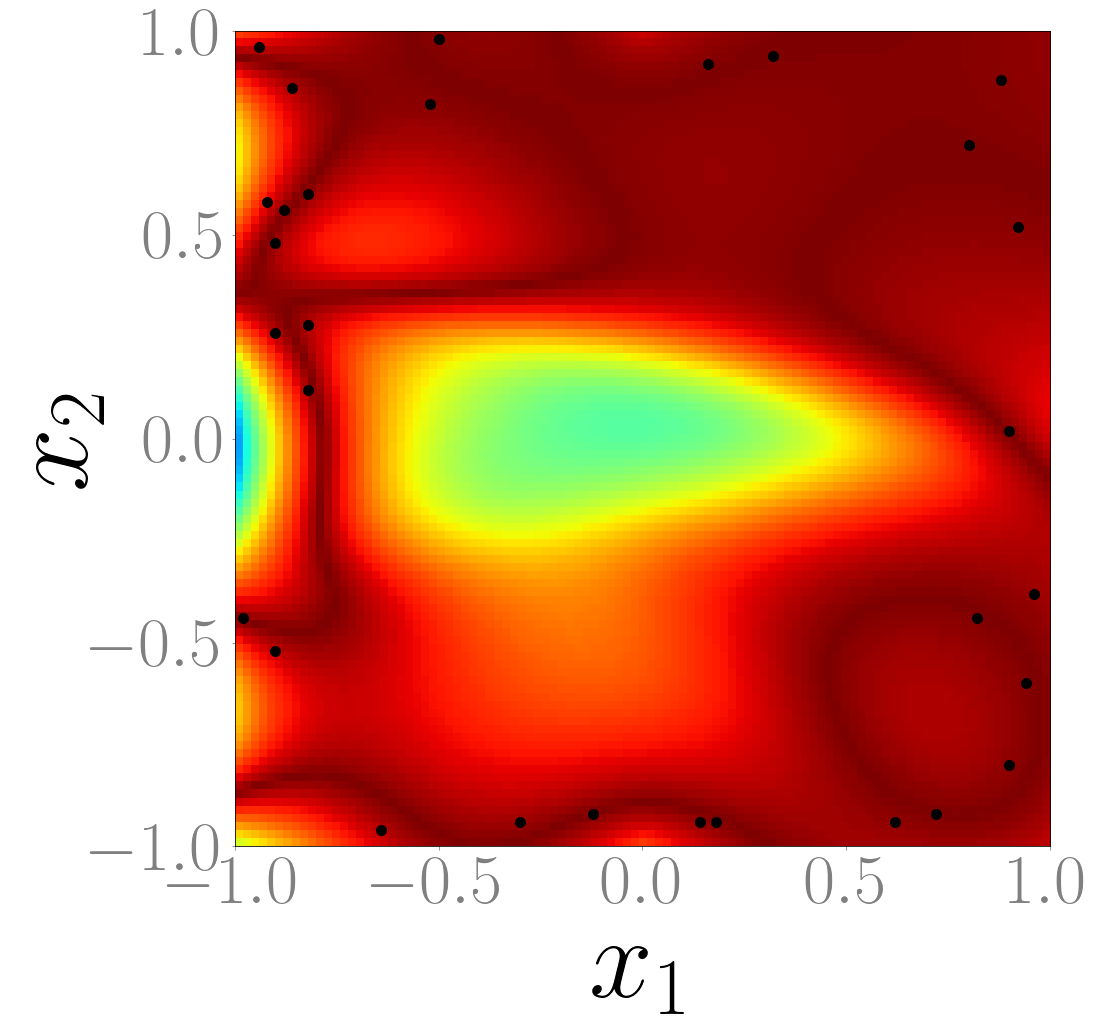

min tensor(2.0191e-06) max tensor(0.9305) mean tensor(0.1477)


In [23]:
# pinn initialisation
lr = 5e-4 # learning rate
pinn, optimiser, scheduler, mse_loss = initialise_pinn(lr)
    
iterations = 1001
lambda_physics = 1e-6 # weighting of physics loss
n = 1000 # number of collocation points
loss_values, pinn = train_pinn(iterations, lambda_physics, n, pinn, optimiser, scheduler, mse_loss)

# Visualize convergence of loss function

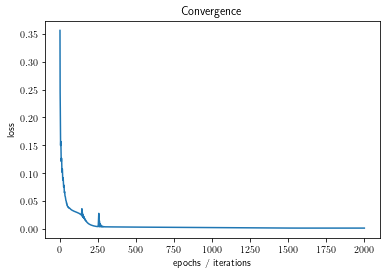

In [13]:
epochs = list(range(1,iterations+1))
fig, ax = plt.subplots()
ax.plot(epochs, loss_values)
ax.set(xlabel='epochs / iterations', 
       ylabel='loss',
       title='Convergence')
#plt.savefig('pinn_loss.jpg', dpi=500, format='jpeg', bbox_inches='tight')
plt.show()